#Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Loading all txt files into single dataframe

In [ ]:
import os
import pandas as pd

# Define the path to the main directory containing the folders
main_directory = '/content/drive/MyDrive/New folder/bbc-fulltext/bbc'

# List of folder names
folders = ['tech', 'politics', 'sport', 'business', 'entertainment']

# Initialize an empty list to store data
data = []

# Iterate through each folder and read the text files
for folder in folders:
    folder_path = os.path.join(main_directory, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                data.append([content, folder])

# Create a DataFrame from the collected data
df = pd.DataFrame(data, columns=['Content', 'Category'])

df.head()


,Content,Category
0,UK pioneers digital film network\n\nThe world'...,tech
1,IBM puts cash behind Linux push\n\nIBM is spen...,tech
2,UK net users leading TV downloads\n\nBritish T...,tech
3,Digital guru floats sub-$100 PC\n\nNicholas Ne...,tech
4,Technology gets the creative bug\n\nThe hi-tec...,tech


#Importing Libraries

In [ ]:
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Text processing functions

In [ ]:
def clean_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    return ' '.join(text)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in stop_words])

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Process the text
df['Content'] = df['Content'].apply(clean_text)
df['Content'] = df['Content'].apply(remove_stopwords)
df['Content'] = df['Content'].apply(lemmatize_text)
df.head()

,Content,Category
0,uk pioneer digital film network world 's first...,tech
1,ibm put cash behind linux push ibm spending $ ...,tech
2,uk net user leading tv downloads british tv vi...,tech
3,digital guru float sub- $ 100 pc nicholas negr...,tech
4,technology get creative bug hi-tech art world ...,tech


#EDA

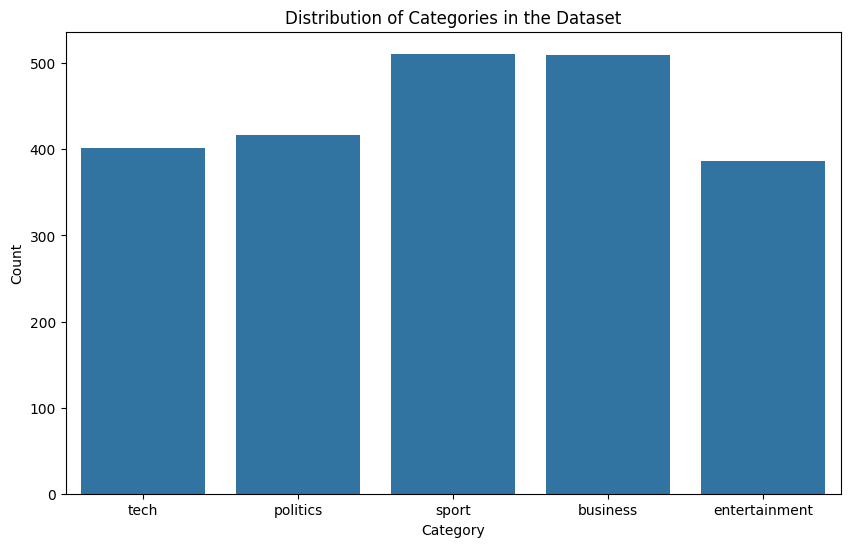

In [ ]:

# 1. Distribution of Categories in the Dataset
plt.figure(figsize=(10, 6))
sns.countplot(x='Category', data=df)
plt.title('Distribution of Categories in the Dataset')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

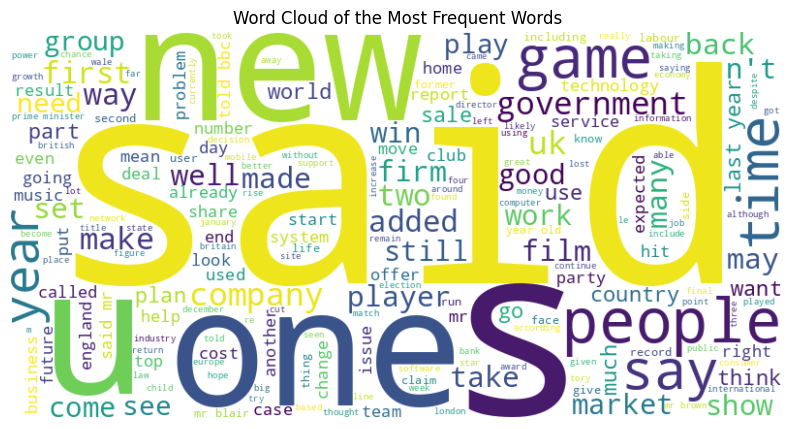

In [ ]:
# 2. Word Cloud of the Most Frequent Words
text = ' '.join(df['Content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of the Most Frequent Words')
plt.axis('off')
plt.show()

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['Category'])

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Content'], df['Category'], test_size=0.2, random_state=42)

# Vectorize text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [ ]:
# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

# Train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluation metrics function
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Evaluate models
metrics_nb = evaluate_model(y_test, y_pred_nb)
metrics_rf = evaluate_model(y_test, y_pred_rf)

print("Naive Bayes - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-score: {:.2f}".format(*metrics_nb))
print("Random Forest - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-score: {:.2f}".format(*metrics_rf))

# Prepare data for CNN
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

# Train CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
cnn_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(len(label_encoder.classes_), activation='softmax'))

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.fit(X_train_pad, y_train, epochs=6, batch_size=32, validation_split=0.2)





Naive Bayes - Accuracy: 0.95, Precision: 0.95, Recall: 0.95, F1-score: 0.95
Random Forest - Accuracy: 0.95, Precision: 0.95, Recall: 0.95, F1-score: 0.95
Epoch 1/6
45/45 [==============================] - 2s 26ms/step - loss: 1.5566 - accuracy: 0.3701 - val_loss: 1.4347 - val_accuracy: 0.5281
Epoch 2/6
45/45 [==============================] - 1s 21ms/step - loss: 1.0186 - accuracy: 0.7402 - val_loss: 0.6356 - val_accuracy: 0.8652
Epoch 3/6
45/45 [==============================] - 2s 35ms/step - loss: 0.2681 - accuracy: 0.9593 - val_loss: 0.2661 - val_accuracy: 0.9129
Epoch 4/6
45/45 [==============================] - 2s 51ms/step - loss: 0.0512 - accuracy: 0.9972 - val_loss: 0.1928 - val_accuracy: 0.9354
Epoch 5/6
45/45 [==============================] - 2s 48ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 0.1675 - val_accuracy: 0.9410
Epoch 6/6
45/45 [==============================] - 2s 33ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.1592 - val_accuracy: 0.9466


In [ ]:
# Evaluate CNN model
y_pred_prob = cnn_model.predict(X_test_pad)
y_pred_cnn = np.argmax(y_pred_prob, axis=1)
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_pad, y_test)
metrics_cnn = evaluate_model(y_test, y_pred_cnn)

14/14 [==============================] - 0s 10ms/step - loss: 0.2775 - accuracy: 0.9146


In [ ]:
print("Naive Bayes - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-score: {:.2f}".format(*metrics_nb))
print("Random Forest - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-score: {:.2f}".format(*metrics_rf))

print("CNN - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-score: {:.2f}".format(*metrics_cnn))

Naive Bayes - Accuracy: 0.95, Precision: 0.95, Recall: 0.95, F1-score: 0.95
Random Forest - Accuracy: 0.95, Precision: 0.95, Recall: 0.95, F1-score: 0.95
CNN - Accuracy: 0.91, Precision: 0.91, Recall: 0.91, F1-score: 0.91


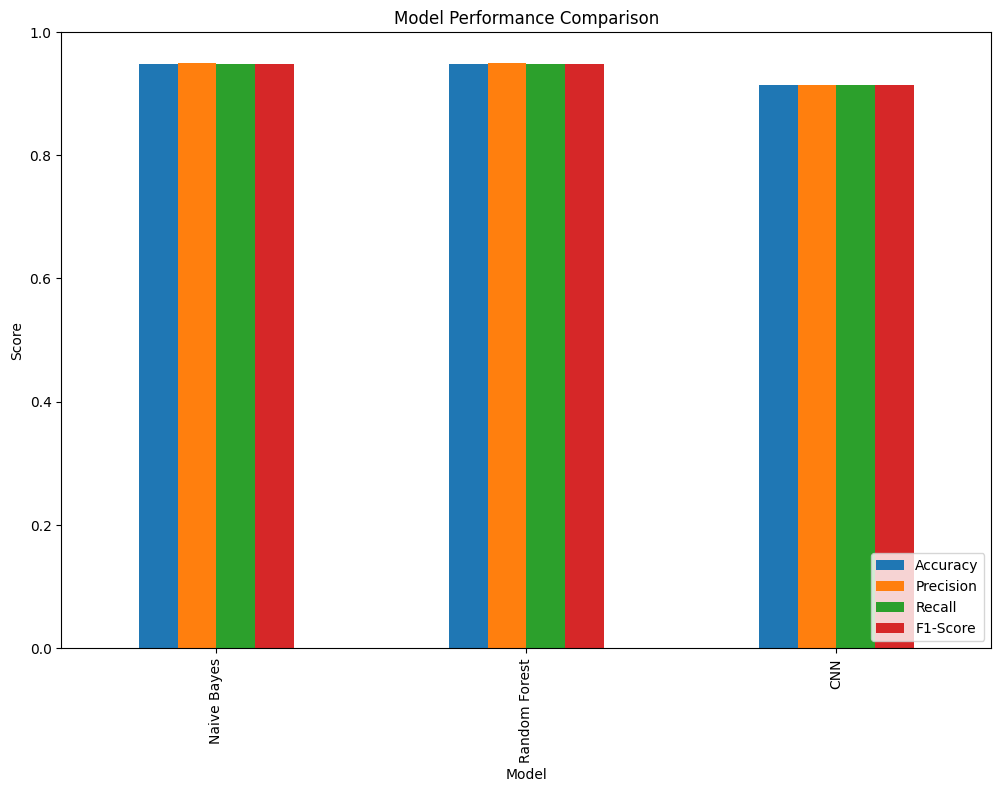

In [ ]:
# Create a DataFrame for comparison
metrics_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'Random Forest', 'CNN'],
    'Accuracy': [metrics_nb[0], metrics_rf[0], metrics_cnn[0]],
    'Precision': [metrics_nb[1], metrics_rf[1], metrics_cnn[1]],
    'Recall': [metrics_nb[2], metrics_rf[2], metrics_cnn[2]],
    'F1-Score': [metrics_nb[3], metrics_rf[3], metrics_cnn[3]]
})

# Plot the comparison
metrics_df.set_index('Model').plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

In [ ]:
df

,Content,Category
0,uk pioneer digital film network world 's first...,4
1,ibm put cash behind linux push ibm spending $ ...,4
2,uk net user leading tv downloads british tv vi...,4
3,digital guru float sub- $ 100 pc nicholas negr...,4
4,technology get creative bug hi-tech art world ...,4
...,...,...
2220,hobbit picture 'four year away' lord ring dire...,1
2221,halloween writer debra hill dy screenwriter pr...,1
2222,french honour director parker british film dir...,1
2223,boogeyman take box office lead low-budget horr...,1


In [ ]:
# To see the mapping of original values to encoded values
encoded_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Original to Encoded Mapping:")
print(encoded_mapping)

Original to Encoded Mapping:
{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}


In [ ]:
# Implementing the recommender system
def recommend_news(user_interest, top_n=5):
    filtered_news = df[df['Category'] == user_interest]
    return filtered_news.head(top_n)

# Example of recommending news based on user interest
user_interest = 'sport'

if user_interest=='business':
  user_interest=0
elif user_interest=='entertainment':
  user_interest=1
elif user_interest=='politics':
  user_interest=2
elif user_interest=='sport':
  user_interest=3
else:
    user_interest=4




recommended_news = recommend_news(user_interest)
print(recommended_news)


                                               Content  Category
818  dibaba break 5,000m world record ethiopia 's t...         3
819  o'sullivan could run world sonia o'sullivan in...         3
820  iaaf launch fight drug iaaf - athletics ' worl...         3
821  claxton hunting first major medal british hurd...         3
822  greene set sight world title maurice greene ai...         3
